In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
epochs=5000
saveFreq=20
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=1
kernel_size=4
stride=2
padding=1

hidden1=128 #Number of channels in hidden layer 1
hidden2=256 
hidden3=512
hidden4=1024
hidden5=1024
fc_dim1=1024*19*19
fc_dim2=1024
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# clfweight=20
advWeight=2
# randFeatureSubset=None
kl_weight=0.0000001
model_str='cnn_vae'
adv=None  #'clf_fc1_eq'  #'clf_fc1_control_eq' #'clf_fc1_control'  #'clf_fc1'

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
training_samples=['control13','disease13','disease8','control8']
# training_samples=['control13','control8']
targetBatch=None
switchFreq=20
diamThresh_mul=608
minThresh_mul=6
name='all_thresh15min6_01'
logsavepath='/mnt/external_ssd/xinyi/log/train_cnn_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_cnn_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_cnn_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

imageslist={}
for s in sampleidx.keys():
    imageslist[s]=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,valNodes,testNodes,ifFlip=True,minCutoff=minThresh_mul,seed=seed)
    
if adv:
    if 'control_eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)
    elif 'control' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)        
    elif 'eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
    else:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0,1,1,1]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([1,0,1,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([1,1,0,1]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,1,1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
        
# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='cnn_vae':
    model = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=mse

if adv=='clf_fc1' or adv=='clf_fc1_eq' or adv=='clf_fc1_control' or adv=='clf_fc1_control_eq':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if adv=='clf_linear1' or adv=='clf_linear1_control':
    modelAdv=gae.gae.model.Clf_linear1(hidden2, dropout,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
        
if use_cuda:
    model.cuda()
    if adv:
        modelAdv.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr_adv, weight_decay=weight_decay)    


In [6]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_kl_train_all=0
    loss_x_train_all=0
    loss_all=0
    for batch_idx, trainInput in enumerate(trainInputloader):
#         print(batch_idx)
        if torch.sum(trainInput)==0:
            print('all zeros '+str(batch_idx))

        if use_cuda:
            trainInput=trainInput.cuda().float()
        optimizerVAEXA.zero_grad()

        recon, z, mu, logvar = model(trainInput)

        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            modelAdv.eval()
            advOut=modelAdv(z)

        loss_kl_train=loss_kl(mu, logvar)
        loss_x_train=loss_x(recon, trainInput)
        loss=loss_kl_train*kl_weight+loss_x_train 
        if torch.isnan(torch.sum(loss_kl_train)):
            print('kl '+str(batch_idx))
        if torch.isnan(torch.sum(mu)):
            print('mu '+str(batch_idx))
        if torch.isnan(torch.sum(logvar)):
            print('logvar '+str(batch_idx))
        if torch.isnan(torch.sum(z)):
            print('z '+str(batch_idx))
        if torch.isnan(torch.sum(loss_x_train)):
            print('x loss '+str(batch_idx))
        if torch.isnan(torch.sum(trainInput)):
            print('x input '+str(batch_idx))
        if torch.isnan(torch.sum(recon)):
            print('x recon '+str(batch_idx))
        
        
        loss_kl_train_all+=loss_kl_train.item()
        loss_x_train_all+=loss_x_train.item()
        loss_all+=loss.item()
        
        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
            loss+=loss_adv_train*advWeight
        loss.backward()
        optimizerVAEXA.step()

    loss_kl_train_all=loss_kl_train_all/len(trainInputloader.dataset)
    loss_x_train_all=loss_x_train_all/len(trainInputloader.dataset)
    loss_all=loss_all/len(trainInputloader.dataset)
    
    model.eval()
    loss_x_val_all=0
    for batch_idx, valInput in enumerate(valInputloader):
        if use_cuda:
            valInput=valInput.cuda().float()
        recon,z, mu, logvar = model(valInput)

        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            advOut=modelAdv(z)

        loss_x_val_all+=loss_x(recon, valInput).item()

        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
            loss_val+=loss_adv_val*advWeight
    loss_x_val_all=loss_x_val_all/len(valInputloader.dataset)
    
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_kl_train: {:.4f}'.format(loss_kl_train_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_x_val: {:.4f}'.format(loss_x_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        print('loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
              'loss_adv_val: {:.4f}'.format(loss_adv_val.item())
             )
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if adv:
        if (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
        else:
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),None,None   
    else:
        return loss_all,loss_kl_train_all,loss_x_train_all,loss_x_val_all      

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
    trainInputnp, valInputnp, _=imageslist[training_samples_t]
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    
    trainInputloader=DataLoader(trainInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    valInputloader=DataLoader(valInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    
    
    if adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],val_loss_x_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0000 loss_train: 0.0776 loss_kl_train: 6492.7821 loss_x_train: 0.0769 loss_x_val: 0.0490 time: 276.8244s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0001 loss_train: 0.0463 loss_kl_train: 50202.3385 loss_x_train: 0.0413 loss_x_val: 0.0388 time: 276.7166s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0002 loss_train: 0.0397 loss_kl_train: 51478.4944 loss_x_train: 0.0346 loss_x_val: 0.0453 time: 276.6890s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0003 loss_train: 0.0649 loss_kl_train: 397120.0411 loss_x_train: 0.0252 loss_x_val: 0.0346 time: 276.6838s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0004 loss_t

disease8 Epoch: 0048 loss_train: 4.7047 loss_kl_train: 47015568.7123 loss_x_train: 0.0031 loss_x_val: 0.0148 time: 286.1253s
disease8 Epoch: 0049 loss_train: 17.0550 loss_kl_train: 170521795.6637 loss_x_train: 0.0028 loss_x_val: 0.0203 time: 286.1350s
disease8 Epoch: 0050 loss_train: 0.0730 loss_kl_train: 703929.1640 loss_x_train: 0.0026 loss_x_val: 0.0238 time: 286.0322s
disease8 Epoch: 0051 loss_train: 106.1444 loss_kl_train: 1061415072.1456 loss_x_train: 0.0029 loss_x_val: 0.0129 time: 286.1368s
disease8 Epoch: 0052 loss_train: 0.0120 loss_kl_train: 94908.5200 loss_x_train: 0.0025 loss_x_val: 0.0157 time: 286.0422s
disease8 Epoch: 0053 loss_train: 0.7994 loss_kl_train: 7970206.3527 loss_x_train: 0.0024 loss_x_val: 0.0179 time: 286.1778s
disease8 Epoch: 0054 loss_train: 905219925906.1068 loss_kl_train: 9052198877509129216.0000 loss_x_train: 0.0027 loss_x_val: 0.0275 time: 286.1369s
disease8 Epoch: 0055 loss_train: 0.2359 loss_kl_train: 2332536.8664 loss_x_train: 0.0026 loss_x_val: 0.

all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0098 loss_train: 3.1558 loss_kl_train: 31535659.9101 loss_x_train: 0.0022 loss_x_val: 0.0218 time: 277.0253s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0099 loss_train: 4.0726 loss_kl_train: 40704212.8550 loss_x_train: 0.0022 loss_x_val: 0.0226 time: 276.9874s
disease13 Epoch: 0100 loss_train: 351.6854 loss_kl_train: 3516797713.9099 loss_x_train: 0.0056 loss_x_val: 0.0372 time: 330.7437s
disease13 Epoch: 0101 loss_train: 3294931664.2865 loss_kl_train: 32949317374482424.0000 loss_x_train: 0.0032 loss_x_val: 0.0252 time: 330.6865s
disease13 Epoch: 0102 loss_train: 20796239.7035 loss_kl_train: 207962399943870.9688 loss_x_train: 0.0030 loss_x_val: 0.0270 time: 330.7552s
disease13 Epoch: 0103 loss_train: 1487.2308 loss_kl_train: 14872279158.9033 loss_x_train: 0.0028 loss_x_val: 0.0477 time: 330.8455s
disease13 

control8 Epoch: 0156 loss_train: 4.3806 loss_kl_train: 43787346.8482 loss_x_train: 0.0019 loss_x_val: 0.0202 time: 286.0713s
control8 Epoch: 0157 loss_train: 34039.1944 loss_kl_train: 340391925978.9864 loss_x_train: 0.0016 loss_x_val: 0.0220 time: 286.1086s
control8 Epoch: 0158 loss_train: 0.1813 loss_kl_train: 1795357.4540 loss_x_train: 0.0018 loss_x_val: 0.0172 time: 286.1189s
control8 Epoch: 0159 loss_train: 1.0461 loss_kl_train: 10445282.5666 loss_x_train: 0.0016 loss_x_val: 0.0197 time: 286.1233s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0160 loss_train: 5689999201999909.0000 loss_kl_train: 56899990605760722632704.0000 loss_x_train: 0.0047 loss_x_val: 0.0559 time: 276.9860s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0161 loss_train: 6162909.6782 loss_kl_train: 61629094348206.5938 loss_x_train: 0.0031 loss_x_val: 0.0222 time: 276.9479s
all zer

disease8 Epoch: 0203 loss_train: 14963051930021512871936.0000 loss_kl_train: 149630522425819696956216180736.0000 loss_x_train: 0.0016 loss_x_val: 0.0275 time: 286.0548s
disease8 Epoch: 0204 loss_train: 14962366594972053929984.0000 loss_kl_train: 149623667840456805548436750336.0000 loss_x_train: 0.0019 loss_x_val: 0.0275 time: 286.1424s
disease8 Epoch: 0205 loss_train: 14961681259922594988032.0000 loss_kl_train: 149616813255093896548471275520.0000 loss_x_train: 0.0017 loss_x_val: 0.0275 time: 286.0958s
disease8 Epoch: 0206 loss_train: 14960997070918370983936.0000 loss_kl_train: 149609968283455196117898100736.0000 loss_x_train: 0.0016 loss_x_val: 0.0275 time: 286.0865s
disease8 Epoch: 0207 loss_train: 14960311735868912041984.0000 loss_kl_train: 149603113698092287117932625920.0000 loss_x_train: 0.0016 loss_x_val: 0.0275 time: 286.1358s
disease8 Epoch: 0208 loss_train: 14959514088386601156608.0000 loss_kl_train: 149595134306996623655347159040.0000 loss_x_train: 0.0018 loss_x_val: 0.0275 ti

all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0252 loss_train: 8.1442 loss_kl_train: 81426463.3426 loss_x_train: 0.0015 loss_x_val: 0.0197 time: 276.9955s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0253 loss_train: 74.9258 loss_kl_train: 749238932.2577 loss_x_train: 0.0019 loss_x_val: 0.0202 time: 276.9679s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0254 loss_train: 39.2342 loss_kl_train: 392326827.1158 loss_x_train: 0.0016 loss_x_val: 0.0205 time: 276.9545s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0255 loss_train: 1796003583.5032 loss_kl_train: 17960035900453510.0000 loss_x_train: 0.0017 loss_x_val: 0.0225 time: 276.9809s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zero

control8 Epoch: 0303 loss_train: 0.6274 loss_kl_train: 6257865.4317 loss_x_train: 0.0016 loss_x_val: 0.0172 time: 286.1183s
control8 Epoch: 0304 loss_train: 0.7651 loss_kl_train: 7637421.3494 loss_x_train: 0.0014 loss_x_val: 0.0170 time: 286.1284s
control8 Epoch: 0305 loss_train: 3495680922872624185344.0000 loss_kl_train: 34956808700041821847122083840.0000 loss_x_train: 0.0018 loss_x_val: 0.0198 time: 286.1329s
control8 Epoch: 0306 loss_train: 3495627631769279791104.0000 loss_kl_train: 34956275138348074722035499008.0000 loss_x_train: 0.0015 loss_x_val: 0.0199 time: 286.1083s
control8 Epoch: 0307 loss_train: 3495627631769281888256.0000 loss_kl_train: 34956275138348092314221543424.0000 loss_x_train: 0.0019 loss_x_val: 0.0198 time: 286.0971s
control8 Epoch: 0308 loss_train: 3495525454165733539840.0000 loss_kl_train: 34955255387785490843941470208.0000 loss_x_train: 0.0018 loss_x_val: 0.0198 time: 286.1122s
control8 Epoch: 0309 loss_train: 3495600986217607856128.0000 loss_kl_train: 34956010

disease13 Epoch: 0349 loss_train: 16.1906 loss_kl_train: 161891756.1035 loss_x_train: 0.0014 loss_x_val: 0.0270 time: 330.7137s
disease13 Epoch: 0350 loss_train: 36.1662 loss_kl_train: 361647085.1432 loss_x_train: 0.0015 loss_x_val: 0.0270 time: 330.7107s
disease13 Epoch: 0351 loss_train: 66.8494 loss_kl_train: 668479170.3598 loss_x_train: 0.0015 loss_x_val: 0.0270 time: 330.7116s
disease13 Epoch: 0352 loss_train: 232.8065 loss_kl_train: 2328050918.4778 loss_x_train: 0.0014 loss_x_val: 0.0270 time: 330.7026s
disease13 Epoch: 0353 loss_train: 234350.4722 loss_kl_train: 2343504625166.2725 loss_x_train: 0.0014 loss_x_val: 0.0270 time: 330.7431s
disease13 Epoch: 0354 loss_train: 870273.7224 loss_kl_train: 8702737176200.8906 loss_x_train: 0.0015 loss_x_val: 0.0270 time: 330.6738s
disease13 Epoch: 0355 loss_train: 0.0650 loss_kl_train: 637074.3537 loss_x_train: 0.0013 loss_x_val: 0.0270 time: 330.7398s
disease13 Epoch: 0356 loss_train: 7349.7452 loss_kl_train: 73497438371.7808 loss_x_train: 

all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0405 loss_train: 37182.5495 loss_kl_train: 371825478180.3752 loss_x_train: 0.0013 loss_x_val: 0.0225 time: 277.0088s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0406 loss_train: 5837676577460790272.0000 loss_kl_train: 58376764778082438563758080.0000 loss_x_train: 0.0013 loss_x_val: 0.0225 time: 276.9904s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0407 loss_train: 2626433912158906368.0000 loss_kl_train: 26264339674301934405156864.0000 loss_x_train: 0.0015 loss_x_val: 0.0226 time: 276.9950s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0408 loss_train: 1638396771137656832.0000 loss_kl_train: 16383966879422079148490752.0000 loss_x_train: 0.0013 loss_x_val: 0.0225 time: 276.91

disease8 Epoch: 0449 loss_train: 17056330337282523398144.0000 loss_kl_train: 170563296511534920723368771584.0000 loss_x_train: 0.0018 loss_x_val: 0.0273 time: 286.0960s
disease8 Epoch: 0450 loss_train: 17056330337282523398144.0000 loss_kl_train: 170563296511534920723368771584.0000 loss_x_train: 0.0015 loss_x_val: 0.0274 time: 286.1192s
disease8 Epoch: 0451 loss_train: 17056314292649259433984.0000 loss_kl_train: 170563135481654392001675657216.0000 loss_x_train: 0.0017 loss_x_val: 0.0273 time: 286.1453s
disease8 Epoch: 0452 loss_train: 17056314292649259433984.0000 loss_kl_train: 170563135481654392001675657216.0000 loss_x_train: 0.0016 loss_x_val: 0.0273 time: 286.1609s
disease8 Epoch: 0453 loss_train: 17056298391271649574912.0000 loss_kl_train: 170562976855204880237958529024.0000 loss_x_train: 0.0017 loss_x_val: 0.0273 time: 286.0556s
disease8 Epoch: 0454 loss_train: 17056298391271649574912.0000 loss_kl_train: 170562976855204880237958529024.0000 loss_x_train: 0.0017 loss_x_val: 0.0272 ti

all zeros 865
control13 Epoch: 0496 loss_train: 40012997900557.7266 loss_kl_train: 400129956056824545280.0000 loss_x_train: 0.0052 loss_x_val: 0.0223 time: 276.9704s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0497 loss_train: 28632724988479.4023 loss_kl_train: 286327237727421005824.0000 loss_x_train: 0.0053 loss_x_val: 0.0221 time: 276.9429s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0498 loss_train: 20481112388496.3477 loss_kl_train: 204811130160489103360.0000 loss_x_train: 0.0052 loss_x_val: 0.0222 time: 276.9507s
all zeros 81
all zeros 86
all zeros 351
all zeros 480
all zeros 502
all zeros 590
all zeros 865
control13 Epoch: 0499 loss_train: 14643666384173.0215 loss_kl_train: 146436666774278750208.0000 loss_x_train: 0.0052 loss_x_val: 0.0223 time: 276.9464s
disease13 Epoch: 0500 loss_train: 7369640209211885568.0000 loss_kl_train: 7369640226300778

control8 Epoch: 0546 loss_train: inf loss_kl_train: inf loss_x_train: 0.0060 loss_x_val: 0.0192 time: 286.0718s
control8 Epoch: 0547 loss_train: inf loss_kl_train: inf loss_x_train: 0.0060 loss_x_val: 0.0193 time: 286.0871s
control8 Epoch: 0548 loss_train: inf loss_kl_train: inf loss_x_train: 0.0058 loss_x_val: 0.0192 time: 286.0819s
control8 Epoch: 0549 loss_train: inf loss_kl_train: inf loss_x_train: 0.0059 loss_x_val: 0.0191 time: 286.1214s
control8 Epoch: 0550 loss_train: inf loss_kl_train: inf loss_x_train: 0.0058 loss_x_val: 0.0192 time: 286.0918s
control8 Epoch: 0551 loss_train: inf loss_kl_train: inf loss_x_train: 0.0059 loss_x_val: 0.0189 time: 286.0728s


KeyboardInterrupt: 

In [7]:
# with open(os.path.join(logsavepath,'train_loss'), 'rb') as input:
#     train_loss_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_kl'), 'rb') as input:
#     train_loss_kl_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_x'), 'rb') as input:
#     train_loss_x_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_a'), 'rb') as input:
#     train_loss_a_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss'), 'rb') as input:
#     val_loss_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_x'), 'rb') as input:
#     val_loss_x_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as input:
#     val_loss_a_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_adv'), 'rb') as input:
#     train_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_adv'), 'rb') as input:
#     val_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_advD'), 'rb') as input:
#     train_loss_advD_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_advD'), 'rb') as input:
#     val_loss_advD_ep[:9360]=pickle.load(input)
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


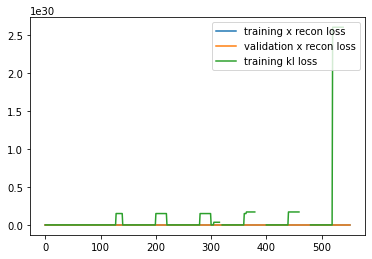

In [9]:
# plt.plot(np.arange(epochs),train_loss_ep)
# plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_advD_ep)*advWeight)
# plt.ylim((0,0.01))
# plt.xlim((0,3000))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
# plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
plt.legend(['training x recon loss','validation x recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


In [ ]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
np.argmin(val_loss_x_ep[:])
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
val_loss_a_ep[8700]

In [ ]:
testepoch=9980
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    _, _, testInputnp=imageslist[s]
    
    testInputloader=DataLoader(testInputnp, batch_size=batchsize, drop_last=False, shuffle=False)
    
    loss_x_test_all=0
    for batch_idx, testInput in enumerate(testInputloader):
        if use_cuda:
            testInput=testInput.cuda().float()
        recon,z, mu, logvar = model(testInput)
        
        if adv and (s in list(sampleLabellist_ae.keys())):
            sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
            modelAdv.eval()
            advOut=modelAdv(z)

        loss_x_test_all+=loss_x(recon, testInput).item()
    loss_x_test_all=loss_x_test_all/len(testInputloader.dataset)

    if adv and (s in list(sampleLabellist_ae.keys())):
        loss_adv_test=loss_adv(advOut,sampleLabel_ae,test_nodes_idx)
        print('loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
        
    print('test results',
          'loss_x_test: {:.4f}'.format(loss_x_test_all))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
   

In [ ]:
y_true=features
y_true_raw=features_raw
preds=features_recon
mask=nodesmask=torch.tensor(np.arange(num_nodes))
reconWeight=20
eps = 1e-10

output,pi,theta,y_pred=preds
nb_case=optimizer.optimizer_nb(preds,y_true,mask,reconWeight,eps = 1e-10,ifmean=False)- torch.log(pi+eps)

zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
result = torch.where(torch.lt(y_true_raw.cuda(), 1), zero_case, nb_case)

In [ ]:
result[:8,:8]

In [ ]:
features[:8,:8]

In [ ]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)

In [ ]:
torch.sum(result[zeroidx])

In [ ]:
# model.pi.weight[:8,:8]
model_str